# Step 0: Mounts and Imports

In [1]:
# Mounting Google Drive
from google.colab import drive, output, files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Main Imports
import scipy.io as sio
import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns           # Used to create confusion heatmaps
import os                       # Used to convert between dataframe and csv
import pywt                     # Used to perform wavelet transform

# Classifier imports
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

In [3]:
# Utils import
!cp /content/drive/MyDrive/Grasp\ Project\ /Data\ /Our\ Model\ [External\ Data\ Analysis/utils_babyscript.py /content
import utils_babyscript as ut

import importlib
importlib.reload(ut)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'utils_babyscript' from '/content/utils_babyscript.py'>

In [4]:
labels = {1: 'Large Diameter Grasp', 2: 'Small Diameter Grasp (power grip)',
          3: 'Fixed Hook Grasp', 4: 'Index Finger Extension Grasp', 5:
          'Medium Wrap', 6: 'Ring Grasp', 7: 'Prismatic Four Fingers Grasp',
          8: 'Stick Grasp', 9: 'Writing Tripod Grasp', 10: 'Power Sphere Grasp',
          11: 'Three Finger Sphere Grasp', 12: 'Precision Sphere Grasp', 13:
          'Tripod Grasp', 14: 'Prismatic Pinch Grasp', 15: 'Tip Pinch Grasp',
          16: 'Quadpod Grasp', 17: 'Lateral Grasp', 18: 'Parallel Extension Grasp',
          19: 'Extension Type Grasp', 20: 'Power Disk Grasp', 21: 'Open a Bottle with a Tripod Grasp',
          22: 'Turn a Screw', 23: 'Cut Something'}

# Step 2: Process Subject 1 EMG data.

In [5]:
# Loads MATLAB file for Subject 1
subject1_file_path = '/content/drive/MyDrive/Grasp Project /Data /Ninapro DB1/Subject_1/S1_A1_E3.mat'
subject1_file_dict = sio.loadmat(subject1_file_path)

In [6]:
# Process EMG data for subject 1 by converting it to a Pandas dataframe
sampling_rate = 100
_, subject1_emg_dataframe = ut.process_ninapro_subject(subject1_file_path, sampling_rate)

Here is where I filtered the data. This is where I used FFT to make sure the data was getting properly filtered.

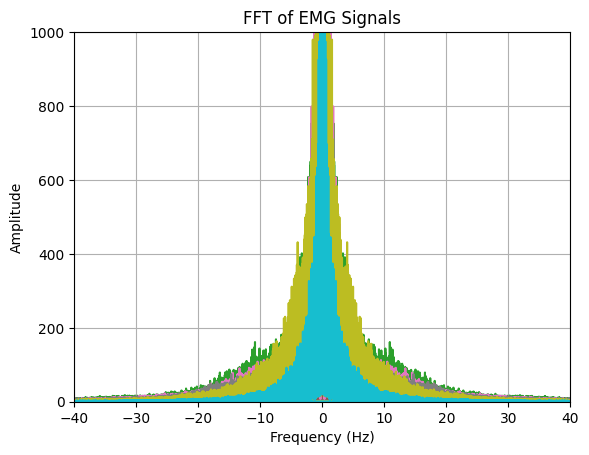

In [7]:
# Perform FFT on emg signal.

from scipy.fft import fft, fftfreq

# Get the EMG data as a numpy array
emg_data = subject1_emg_dataframe.iloc[:, 1:].values
num_samples, num_channels = emg_data.shape

# Calculate the FFT for each channel
emg_fft = fft(emg_data, axis=0)

# Calculate the corresponding frequencies
frequencies = fftfreq(num_samples, 1 / sampling_rate)

# Plot the FFT results
plt.figure()
for i in range(num_channels):
    plt.plot(frequencies, np.abs(emg_fft[:, i]))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of EMG Signals')
plt.grid(True)
plt.ylim(0, 1000)  # Set y-axis limit
plt.xlim(-40, 40)
plt.show()

In [8]:
# Separate EMG filtering function
def filter_emg_data(data, sampling_rate):
  data_copy = data.copy()

  # Keeps time column from being filtered
  if 'Time' in data.columns:
    time_data = data['Time']
    data_copy = data_copy.drop(columns='Time')
    emg_columns = data_copy.columns # Store EMG column names
  else:
    time_data = None
    emg_columns = data_copy.columns # Store EMG column names


  # Low pass, cutoff frequency of 2 Hz
  low_cutoff = 2
  nyq = 0.5 * sampling_rate
  b,a = scipy.signal.butter(2, low_cutoff / nyq, btype='low')
  # Use the correct column names for the filtered EMG data
  data_copy = pd.DataFrame(scipy.signal.filtfilt(b, a, data_copy.values, axis=0), columns=emg_columns)

  # Apply RMS (Root Mean Square) envelope

  # Define windows
  window_size = 25
  num_samples = data_copy.shape[0]
  num_windows = num_samples // window_size

  # Creates a new dataframe with the RMS values
  # The columns for the RMS dataframe should also be the EMG columns
  rms_dataframe = pd.DataFrame(columns=emg_columns)
  for column in data_copy.columns:
    rms_values = []
    for i in range(num_windows):
      start_index = i * window_size
      end_index = start_index + window_size
      window_data = data_copy.iloc[start_index:end_index, data_copy.columns.get_loc(column)]
      rms_value = np.sqrt(np.mean(window_data**2))
      rms_values.append(rms_value)
    rms_dataframe[column] = rms_values

  # Add back time column
  if time_data is not None:
    # Need to adjust the time_data to match the reduced number of rows after RMS
    # Assuming the RMS windows are non-overlapping and the time corresponds to the start of the window
    # A more accurate approach might be to use the time at the center of the window
    # For simplicity here, we'll take the time values corresponding to the start of each window
    time_data_rms = time_data.iloc[::window_size].reset_index(drop=True)
    # Ensure the number of time points matches the number of RMS rows
    if len(time_data_rms) > len(rms_dataframe):
        time_data_rms = time_data_rms.iloc[:len(rms_dataframe)]
    rms_dataframe.insert(0, 'Time', time_data_rms)


  return rms_dataframe

In [9]:
# Try new filtering function
subject1_newfilter_emg_dataframe = filter_emg_data(subject1_emg_dataframe, sampling_rate)

In [ ]:
# Filter data using a 6 Hz low-pass butterworth filter on a data singal.
emg_sampling_rate = 100
subject1_filtered_emg_dataframe = ut.filter_data(subject1_emg_dataframe,
                                                 emg_sampling_rate,
                                                'emg')

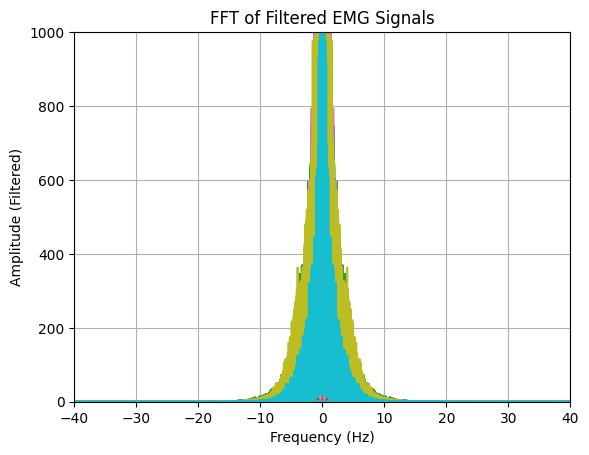

In [ ]:
#Perform FFT in the same way as before filtering with the same dimensinos

import matplotlib.pyplot as plt
import numpy as np
# Get the filtered EMG data as a numpy array
filtered_emg_data = subject1_filtered_emg_dataframe.iloc[:, 1:].values
filtered_num_samples, filtered_num_channels = filtered_emg_data.shape

# Calculate the FFT for each filtered channel
filtered_emg_fft = fft(filtered_emg_data, axis=0)

# Calculate the corresponding frequencies (should be the same as original data)
filtered_frequencies = fftfreq(filtered_num_samples, 1 / emg_sampling_rate)

# Plot the FFT results of the filtered data
plt.figure()
for i in range(filtered_num_channels):
    plt.plot(filtered_frequencies, np.abs(filtered_emg_fft[:, i]))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (Filtered)')
plt.title('FFT of Filtered EMG Signals')
plt.grid(True)
plt.ylim(0, 1000)  # Set y-axis limit, possibly adjust based on filtered data amplitude
plt.xlim(-40, 40)
plt.show()

In [ ]:
# Normalize EMG data, using 0 as the minimum and 1 as the 95th percentile signal

'''
normalize_emg_data(filtered_dataframe)
'''
def normalize_emg_data(filtered_dataframe):
  normalized_dataframe = pd.DataFrame(index=filtered_dataframe.index)
  for column in filtered_dataframe.columns:
    if column == 'Time':
      normalized_dataframe[column] = filtered_dataframe[column]
      continue
    column_min =filtered_dataframe[column].min()
    column_max = np.percentile(filtered_dataframe[column], 95)
    if column_max == column_min:
      normalized_dataframe[column] = 0
    else:
      normalized_dataframe[column] = (filtered_dataframe[column] - column_min) / (column_max - column_min)
  return normalized_dataframe


In [ ]:
subject1_normalized_emg_data = normalize_emg_data(subject1_filtered_emg_dataframe)

In [ ]:
# Segment the data based on restimulus file. Results in a list of dataframes.
subject1_restimulus_data = subject1_file_dict['restimulus']
restim_timestamps, restim_labels = ut.gather_restim_timestamps_and_labels(subject1_restimulus_data)
subject1_emg_trials = ut.segment_data(subject1_normalized_emg_data, restim_timestamps)

# Segmentation based on stimulus data (for visualization only)
subject1_stimulus_data = subject1_file_dict['stimulus']
stim_timestamps, stim_labels = ut.gather_restim_timestamps_and_labels(subject1_stimulus_data)
subject1_emg_trials_stim = ut.segment_data(subject1_normalized_emg_data, stim_timestamps)

# Raw EMG trials for reference (for visualization only)
raw_emg_trials_stim = ut.segment_data(subject1_emg_dataframe, stim_timestamps)

Visualization of fully processed EMG data for one grasp type, with a 100 Hz sampling rate:

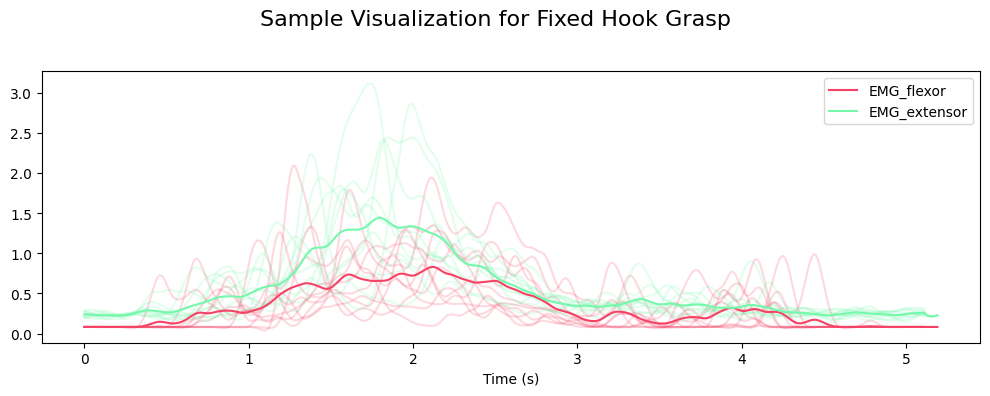

In [ ]:
ut.visualize_full_grasp(subject1_emg_trials_stim, 3, ['EMG_flexor', 'EMG_extensor'])

For reference, here is a visualizaition of the same EMG data before it is filtered and normalized.

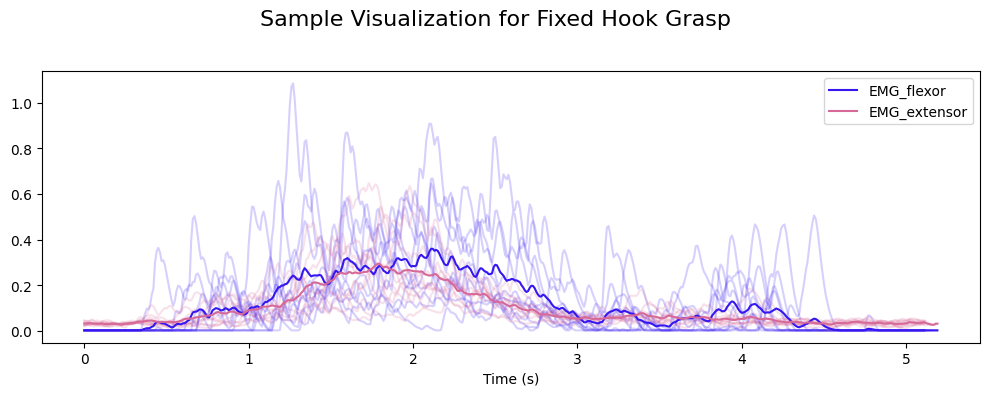

In [ ]:
ut.visualize_full_grasp(raw_emg_trials_stim, 3, ['EMG_flexor', 'EMG_extensor'])

# Step 3: Extract features from Subject 1 EMG data.

In [ ]:
# EMG data: Extract time features along with some frequency domain features.
'''
get_emg_features(emg_data)

Purpose: Extract time-based and frequency-based features for each EMG electrode
measured in Ninapro DB1.
Parameters: segmented EMG data (list of Pandas dataframes)
Output: List of EMG features for each trial (2D list). Each EMG electrode
contributes a MAV (mean absolute value), variance, waveform length, HST
(histogram), and DWT (discrete wavelet transform) to that trial.
'''
def get_emg_features(emg_data):
  results = []
  # Loops over each trial
  for trial in emg_data:
    trial_features = []
    for column in trial.columns:
      if column == 'Time':
        continue
      else:
        # Time-based extracted featuers: MAV (mean absolute value), variance,
        # waveform length, sEMG histogram, zero crossing
        signal = trial[column]
        mav = float(np.mean(np.abs(signal)))
        variance = np.var(signal)
        waveform_length = float(np.sum(np.abs(np.diff(signal))))
        histogram, _ = np.histogram(signal, bins=10, density=True)
        # Frequency domain features: DWT (discrete wavelet transform). may add STFT
        dwt = pywt.wavedec(signal, 'db4', level=4)
        # Take RMS of each band
        dwt_rms = [float(np.sqrt(np.mean(band**2))) for band in dwt]
        # Converts numpy floats into regular floats
        trial_features.extend([mav, variance, waveform_length] + histogram.tolist() + dwt_rms)
    results.append(trial_features)
  return results

In [ ]:
subject1_emg_features = get_emg_features(subject1_emg_trials)

In [ ]:
# Remove features that have little influence on the outcome of the ML prediction
def remove_unimportant_features(features, labels):
    """
    Removes features with low importance based on a Random Forest model.

    Args:
        features (list or np.ndarray): The feature data (each row is a sample, each column is a feature).
        labels (list or np.ndarray): The corresponding labels for each sample.

    Returns:
        np.ndarray: The feature data with unimportant features removed.
        list: The indices of the features that were kept.
    """
    # Ensure features are in a numpy array format
    features = np.array(features)
    labels = np.array(labels)

    if features.ndim != 2:
        raise ValueError("Features must be a 2D array.")
    if len(features) != len(labels):
         raise ValueError("Number of samples in features and labels must match.")

    # Train a Random Forest Classifier to get feature importances
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(features, labels)

    # Get feature importances
    importances = model.feature_importances_

    # Perform permutation importance (can be more robust than feature_importances_)
    # We will use permutation importance as a second check/alternative if needed, but let's start with feature_importances_
    # result = permutation_importance(model, features, labels, n_repeats=10, random_state=42, n_jobs=-1)
    # perm_importances = result.importances_mean

    # Determine a threshold for feature importance. This is a heuristic.
    # A common approach is to remove features with importance below a certain percentage
    # or below the mean importance. Let's try removing features with importance less than 0.01
    # or alternatively, less than the mean importance.
    importance_threshold = 0.002 # Example threshold, can be tuned
    # importance_threshold = np.mean(importances) # Alternative threshold

    # Identify indices of important features
    important_feature_indices = np.where(importances >= importance_threshold)[0]

    if len(important_feature_indices) == 0:
        print("Warning: No features found above the importance threshold. Consider lowering the threshold.")
        # Return all features in this case, or handle as appropriate
        return features, list(range(features.shape[1]))


    # Filter the features based on the important indices
    filtered_features = features[:, important_feature_indices]

    print(f"Original number of features: {features.shape[1]}")
    print(f"Number of features kept: {filtered_features.shape[1]}")

    return filtered_features, important_feature_indices.tolist()


In [ ]:
filtered_features, kept_feature_list = remove_unimportant_features(subject1_emg_features, restim_labels)

# Step 4: Create a simple ML model for Subject 1.

In [ ]:
# Deifne x (features) and y (labels)
x = subject1_emg_features
y = restim_labels

In [ ]:
# Split the EMG data into test and training groups using a 80/20 data split.
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2,
                                                                    random_state=0)

In [ ]:
# Scale features.
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# Random Forest Classifier
emg_random_forest_model = RandomForestClassifier()
'''
bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                                     criterion='gini', max_depth=None, max_features='sqrt',
                                                     max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                                                     min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                     monotonic_cst=None, n_estimators=200, n_jobs=None, oob_score=False,
                                                     random_state=None, verbose=0, warm_start=False
'''

emg_random_forest_model.fit(x_train, y_train)

# Test the accuracy of the model.
y_predicted = emg_raw_random_forest_model.predict(x_test)
accuracy = accuracy_score(y_test, y_predicted)

# Gets parameters of the model
print(f'Random Forest Accuracy: {accuracy}')
params = emg_raw_random_forest_model.get_params()
print('RF Parameters:')
print(params)

Random Forest Accuracy: 0.9565217391304348
RF Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


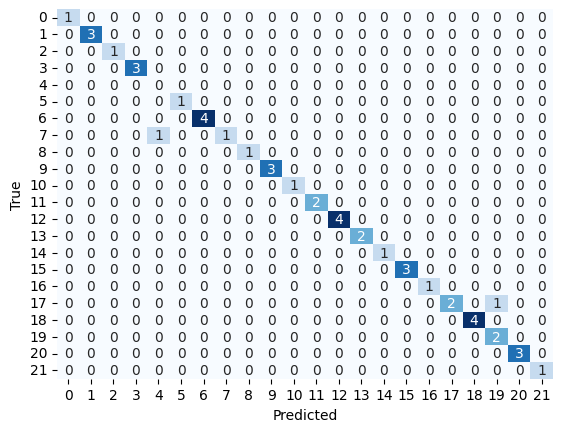

In [ ]:
# Seaborn confusion matrix
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, cmap='Blues', fmt='g',
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Step 5: Combine the EMG data for all participants.

In [ ]:
# Create a list of folders with all Ninapro DB1 subjects
ninaproDB1_folder_path = '/content/drive/MyDrive/Grasp Project /Data /Ninapro DB1'
subject_folders = os.listdir(ninaproDB1_folder_path)

In [ ]:
'''
get_emg_features_and_labels(subject_folder)

Purpose:
Parameters:
Output:
'''

def get_emg_features_and_labels(subject_folder):

  # Get path for folder
  subject_folder_path = os.path.join(ninaproDB1_folder_path, subject_folder)

  # Find data path for correct file using subject number
  subject_number = ut.find_subject_number(subject_folder)
  subject_data_path = subject_folder_path + f'/S{subject_number}_A1_E3.mat'
  print(f'Processing Subject #{subject_number}...')

  # Extract and filter EMG data from file
  _, subject_emg_data = ut.process_ninapro_subject(subject_data_path, 100)
  subject_filtered_emg_data = ut.filter_data(subject_emg_data, 100, 'emg')

  # Normalize data
  subject_normalized_emg_data = normalize_emg_data(subject_filtered_emg_data)

  # Segment data
  subject_restim_data = sio.loadmat(subject_data_path)['restimulus']
  restim_timestamps, restim_labels = ut.gather_restim_timestamps_and_labels(subject_restim_data)
  subject_emg_trials = ut.segment_data(subject_normalized_emg_data, restim_timestamps)

  # Extract kinematic features
  subject_emg_features = get_emg_features(subject_emg_trials)

  return subject_emg_features, restim_labels

In [ ]:
def process_all_subjects_emg(folder_list):
  all_emg_features = []
  all_labels = []
  for folder in folder_list:
    # Skip saved csv files and outliers
    if folder in ['all_kinematic_features.csv', 'all_emg_features.csv',
                  'all_kinematic_labels.csv', 'all_combined_features.csv',
                  'Subject_27']:
      continue
    else:
      # Get features
      subject_emg_features, subject_labels = get_emg_features_and_labels(folder)
      all_emg_features.extend(subject_emg_features)
      all_labels.extend(subject_labels)
  print('Done!')
  return all_emg_features, all_labels

all_emg_features, all_labels = process_all_subjects_emg(subject_folders)

In [ ]:
# This takes a long time to process! Here I will save all the results as a csv.
ut.features_to_csv(all_emg_features, 'all_emg_features.csv')
ut.features_to_csv(all_labels, 'all_kinematic_labels.csv')

In [ ]:
# Converts csv files back into useable features data
all_emg_features = ut.csv_to_features('all_emg_features.csv')
all_labels = ut.csv_to_features('all_kinematic_labels.csv')

Here I will determine the most important features for the model.

In [ ]:
# prompt: Determine the most important features for the model based on the get_emg_features function. This should be across all subjects and return a ranking of MAV, Variance, Wafeforlm length, histogram, and dwt rms. The goal is to figur eout which features to keep per emg location.

def rank_emg_features(features, labels, n_channels=12, n_histogram_bins=10):
    """
    Ranks the importance of different EMG feature types across all channels.

    Args:
        features (list or np.ndarray): The feature data for all subjects combined.
                                      Each row is a sample, each column is a feature.
        labels (list or np.ndarray): The corresponding labels for each sample.
        n_channels (int): The number of EMG channels. Default is 12 for Ninapro DB1.
        n_histogram_bins (int): The number of bins used for the histogram feature. Default is 10.

    Returns:
        dict: A dictionary where keys are feature names (MAV, Variance, Waveform Length,
              Histogram, DWT RMS) and values are their average importance across channels.
    """
    features = np.array(features)
    labels = np.array(labels)

    if features.ndim != 2:
        raise ValueError("Features must be a 2D array.")
    if len(features) != len(labels):
         raise ValueError("Number of samples in features and labels must match.")

    # Train a Random Forest Classifier
    model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                                  criterion='gini', max_depth=None, max_features='sqrt',
                                                  max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                                                  min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                  monotonic_cst=None, n_estimators=100, n_jobs=None, oob_score=False,
                                                  random_state=None, verbose=0, warm_start=False)
    model.fit(features, labels)

    # Get feature importances
    importances = model.feature_importances_

    # The get_emg_features function extracts features in a specific order for each channel:
    # [MAV, Variance, Waveform Length] + histogram.tolist() + dwt_rms
    # Let's determine the number of DWT RMS features.
    # The get_emg_features function uses pywt.wavedec(signal, 'db4', level=4).
    # The output of wavedec is a list of coefficients for each decomposition level
    # plus the approximation coefficients. For level=4, there are 4 detail coefficient
    # arrays and 1 approximation coefficient array, totaling 5 arrays.
    # The dwt_rms is calculated for each of these bands. So there are 5 DWT RMS features per channel.
    n_dwt_rms_features = 5

    # Total features per channel: 3 (MAV, Variance, Waveform Length) + n_histogram_bins + n_dwt_rms_features
    features_per_channel = 3 + n_histogram_bins + n_dwt_rms_features

    if features.shape[1] != n_channels * features_per_channel:
        print(f"Warning: The number of features ({features.shape[1]}) does not match the expected number based on channels ({n_channels}) and feature types ({features_per_channel}). Check the feature extraction logic.")
        # Attempt to proceed but the ranking might be incorrect if the structure is unexpected
        # This is a safeguard, but ideal is for this check to pass.

    # Calculate the average importance for each feature type across all channels
    feature_importances_dict = {
        'MAV': [],
        'Variance': [],
        'Waveform Length': [],
        'Histogram': [],
        'DWT RMS': []
    }

    for i in range(n_channels):
        start_index = i * features_per_channel

        # MAV
        feature_importances_dict['MAV'].append(importances[start_index])

        # Variance
        feature_importances_dict['Variance'].append(importances[start_index + 1])

        # Waveform Length
        feature_importances_dict['Waveform Length'].append(importances[start_index + 2])

        # Histogram
        histogram_importances = importances[start_index + 3 : start_index + 3 + n_histogram_bins]
        feature_importances_dict['Histogram'].append(np.mean(histogram_importances)) # Average importance of histogram bins

        # DWT RMS
        dwt_rms_importances = importances[start_index + 3 + n_histogram_bins : start_index + 3 + n_histogram_bins + n_dwt_rms_features]
        feature_importances_dict['DWT RMS'].append(np.mean(dwt_rms_importances)) # Average importance of DWT bands


    # Calculate the average importance across all channels for each feature type
    average_importances = {
        key: np.mean(values) for key, values in feature_importances_dict.items()
    }

    # Rank features by importance (descending order)
    ranked_features = sorted(average_importances.items(), key=lambda item: item[1], reverse=True)

    print("Feature Importance Ranking (Average across all channels):")
    for feature, importance in ranked_features:
        print(f"- {feature}: {importance:.4f}")

    return dict(ranked_features)

# Assuming 'all_emg_features' and 'all_labels' are already loaded from the CSVs
# (as done in the preceding code)

# Determine the feature importance ranking
feature_ranking = rank_emg_features(all_emg_features, all_labels)


# Step 7: Train new Random Forest classifier with full EMG database.

In [ ]:
# Define x (features) and y (labels)
x = all_emg_features
y = all_labels

In [ ]:
# Split into test and training groups. Will use an 80/20 split.
trials_per_subject=230

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=trials_per_subject,
                                                                    random_state=0)

In [ ]:
# Scales the data.
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# Create a basic random forest classifier
full_random_forest_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                                  criterion='gini', max_depth=None, max_features='sqrt',
                                                  max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                                                  min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                  monotonic_cst=None, n_estimators=100, n_jobs=None, oob_score=False,
                                                  random_state=None, verbose=0, warm_start=False)
full_random_forest_model.fit(x_train, y_train)

# Test the accuracy of the model
y_predicted = full_random_forest_model.predict(x_test)
accuracy = accuracy_score(y_test, y_predicted)

# Gets parameters of the model
print(f'Random Forest Accuracy: {accuracy}')
params = full_random_forest_model.get_params()
print('RF Parameters:')
print(params)

'''
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False
'''

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Accuracy: 0.6695652173913044
RF Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


"\n{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False\n"

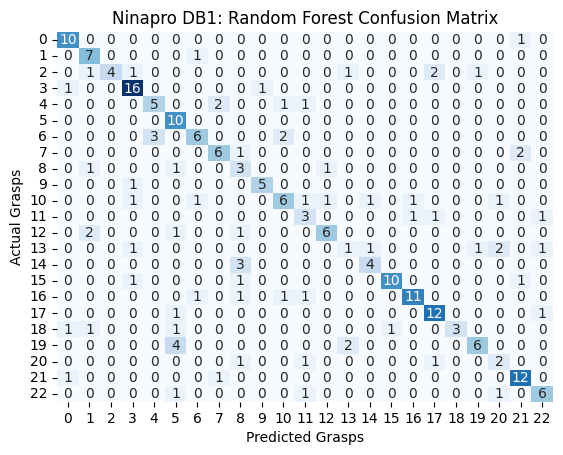

In [ ]:
# Visualize the confusion matrix with a Seaborn heatmap
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, cmap='Blues',
            cbar=False)
plt.xlabel('Predicted Grasps')
plt.ylabel('Actual Grasps')
plt.title('Ninapro DB1: Random Forest Confusion Matrix')
plt.show()